# Data 620 - Project 3

Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen

## Project description

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

## Load libraries.

In [1]:
import random
from collections import Counter
import nltk
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data loading/preparation

In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from which we should be able to create numerous features from.

### Load and shuffle data.

In [53]:
# read in names from the files
# names to be lowercase for easy recognition 
download('names')
males = [name.lower().strip() for name in names.words('male.txt')]
females = [name.lower().strip() for name in names.words('female.txt')]

#Remove unisex names from each list.
#Did not run this previously, but I think it is reasonable to do so.
#Otherwise accuracy unfairly penalized if a unisex name is listed as one gender in training and another in test.
#Will be marked as wrong even if the model is otherwise perfect.

unisex = list(set(males) & set(females))
[males.remove(name) for name in unisex]
[females.remove(name) for name in unisex]

#Add sex labels.
males = [(name,'male') for name in males]
females = [(name,'female') for name in females]

# combine lists of names
all_names = males + females

# randomize the list
random.seed(13)
random.shuffle(all_names)

[nltk_data] Downloading package names to /Users/hmgeiger/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Feature creation

Features are the most important part of what goes into a machine learning model. For that reason, it is critically important to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier, we will put our data in a Pandas dataframe.

In [3]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,lester,male
1,ritch,male
2,joshua,male
3,skippie,male
4,peggy,female


In [4]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,lester,male,6,l,r,False,False,ee,lstr,2,4,"[(l, e), (e, s), (s, t), (t, e), (e, r)]","[(l, e, s), (e, s, t), (s, t, e), (t, e, r)]",2
1,ritch,male,5,r,h,False,False,i,rtch,1,4,"[(r, i), (i, t), (t, c), (c, h)]","[(r, i, t), (i, t, c), (t, c, h)]",1
2,joshua,male,6,j,a,True,False,oua,jsh,3,3,"[(j, o), (o, s), (s, h), (h, u), (u, a)]","[(j, o, s), (o, s, h), (s, h, u), (h, u, a)]",2
3,skippie,male,7,s,e,True,False,iie,skpp,3,4,"[(s, k), (k, i), (i, p), (p, p), (p, i), (i, e)]","[(s, k, i), (k, i, p), (i, p, p), (p, p, i), (...",2
4,peggy,female,5,p,y,False,False,e,pggy,1,4,"[(p, e), (e, g), (g, g), (g, y)]","[(p, e, g), (e, g, g), (g, g, y)]",2


In [5]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(p, e), (e, g), (g, g), (g, y), (m, a), (a, y...","[(p, e, g), (e, g, g), (g, g, y), (m, a, y), (...","{('p', 'e'): 39, ('e', 'g'): 22, ('g', 'g'): 1...","{('p', 'e', 'g'): 5, ('e', 'g', 'g'): 8, ('g',..."
male,"[(l, e), (e, s), (s, t), (t, e), (e, r), (r, i...","[(l, e, s), (e, s, t), (s, t, e), (t, e, r), (...","{('l', 'e'): 168, ('e', 's'): 72, ('s', 't'): ...","{('l', 'e', 's'): 12, ('e', 's', 't'): 22, ('s..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12% of the male names.

## Data exploration

Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [6]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.186920,0.737319,0.176344,2.701705,3.485215,2.498165
male,5.995733,0.224593,0.159426,2.221102,3.774631,2.061676


In [7]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel. These appear to be good predictors. We need to visual confirm what we see numerically.

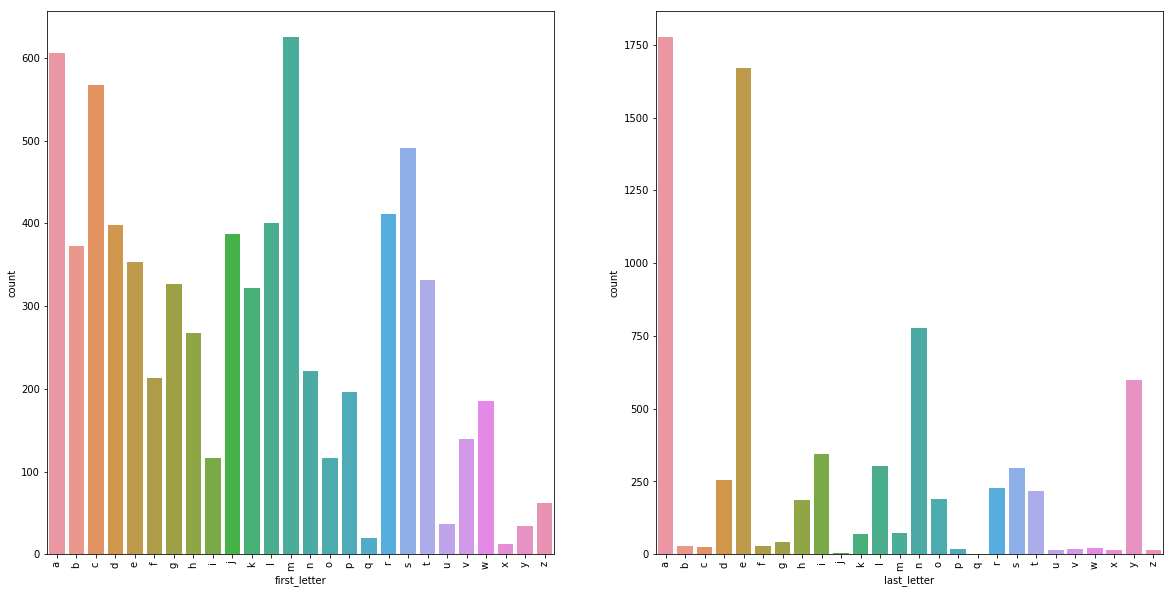

In [8]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot,order = list(string.ascii_lowercase))
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

The distributions above don't tell us much. We need to condition on gender.

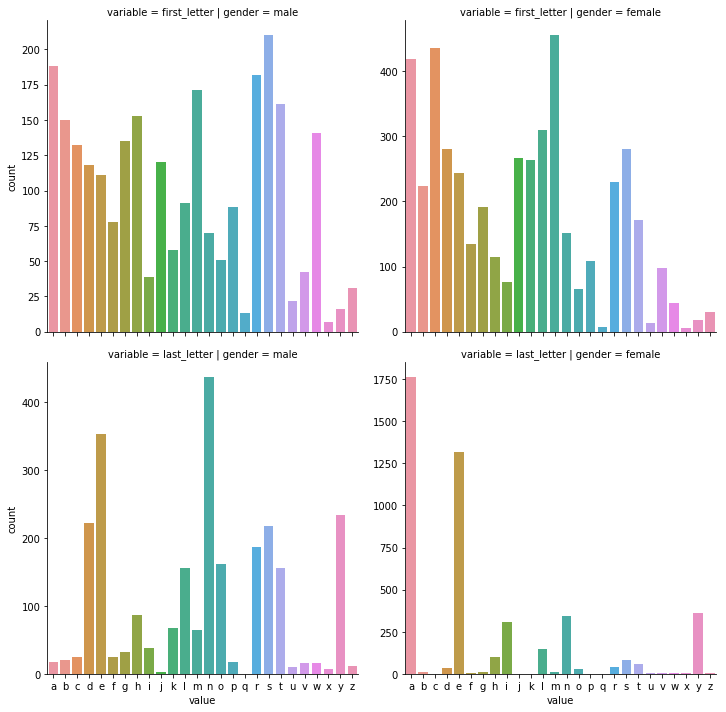

In [9]:
data_melted = pd.melt(data[['gender','first_letter','last_letter']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            order = list(string.ascii_lowercase),
            sharey = False)

plt.show()

It would appear that both the first and the last letter could be pretty good predictors for gender.

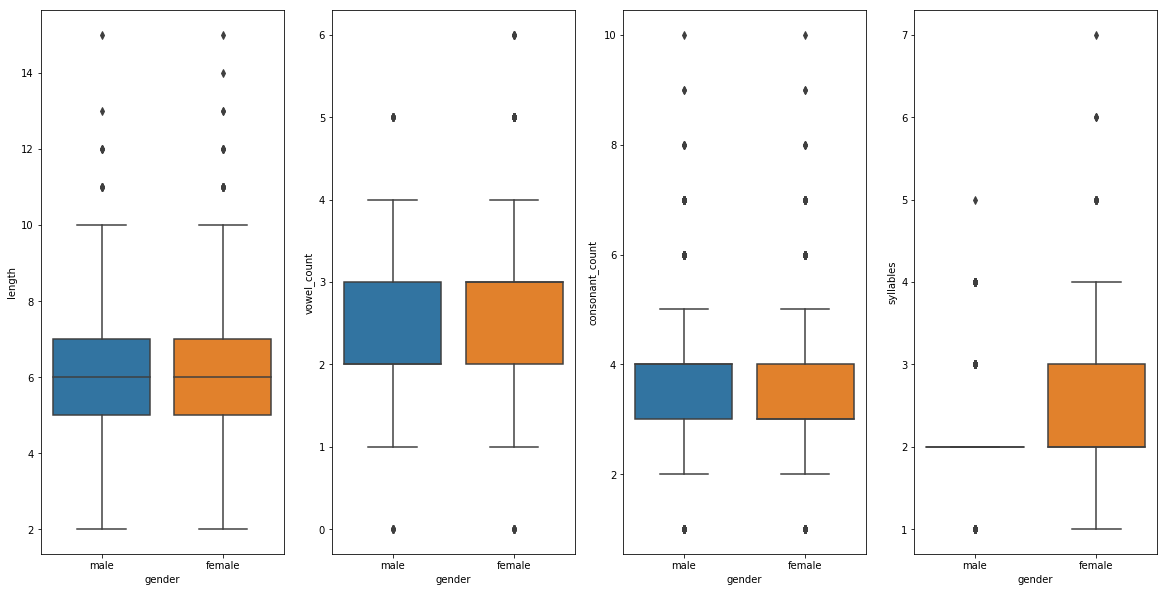

In [10]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)

Baron had said: from the boxplots above, we can safely rule out vowel count, consonant count, and length as strong predictors of gender. Syllables, however, seems like it may be a good predictor.

However, I am wondering if boxplots are necessarily the best way to look at these variables, as they are integers with a fairly narrow range.

Let's try a conditional count plot for each of these variables like we did for first and last letter.

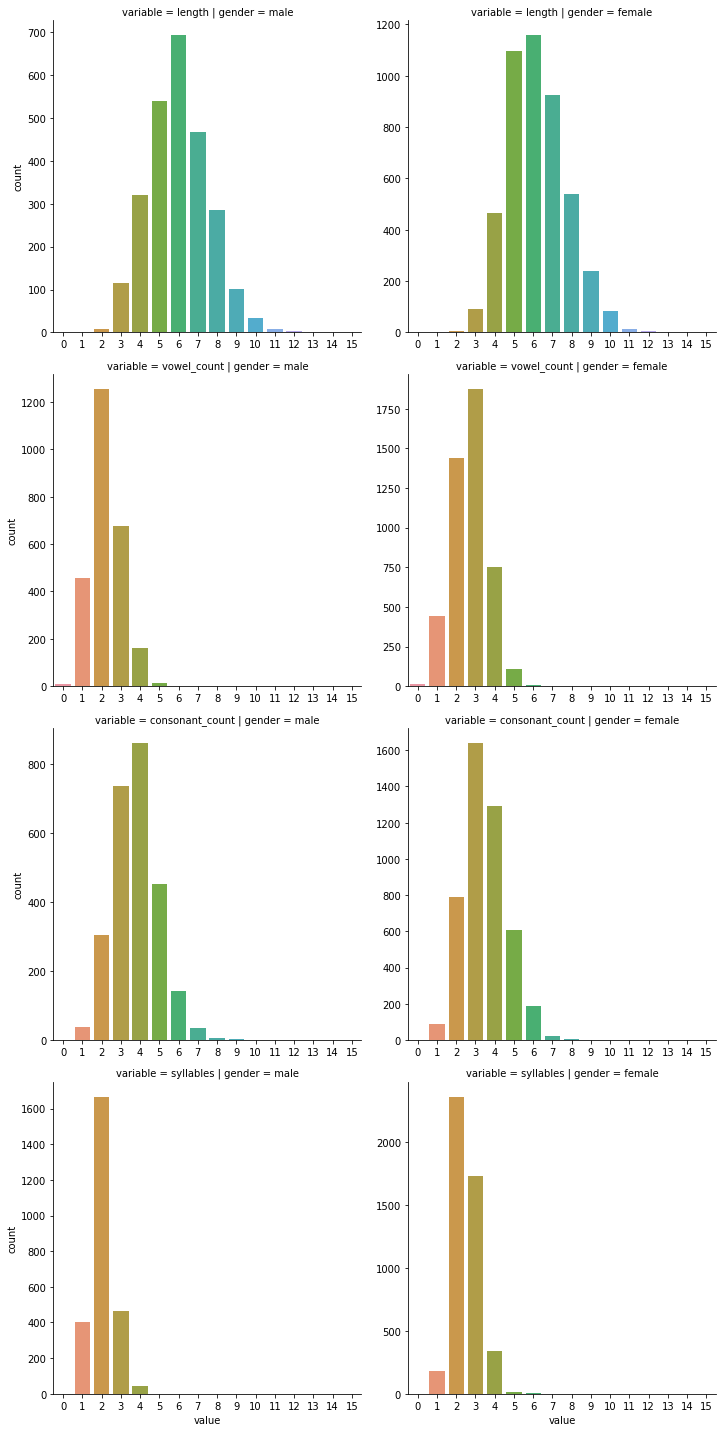

In [11]:
data_melted = pd.melt(data[['gender','length','vowel_count','consonant_count','syllables']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            sharey = False,sharex=False)

plt.show()

Looks like the conclusion still mostly holds that we can exclude length, vowel count, and consonant count.

## Feature generation

### Feature generation function

This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach. As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier. Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.

In [12]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

### Training/test split and apply feature generation function.

In [13]:
# create each set of data
#The instructions specify using 7900 total names for the two tests and training.
#However, we do not have enough names for that after removing unisex names.
#So, just take all but the first 500 for training + dev test.
final_test = all_names[:500]
num_remaining = len(all_names) - 500
training_and_dev_test = all_names[-num_remaining:]

#Separate the training and dev test data.
#We will call these "dev_test1" and "training1".

dev_test1 = training_and_dev_test[:500]
training1 = training_and_dev_test[500:]

#Shuffle to create four additional training vs. dev-test splits.

random.shuffle(training_and_dev_test)
dev_test2 = training_and_dev_test[:500]
training2 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test3 = training_and_dev_test[:500]
training3 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test4 = training_and_dev_test[:500]
training4 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test5 = training_and_dev_test[:500]
training5 = training_and_dev_test[500:]

# apply feature generation function
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonor

## Apply model.

### Initial model

Now that we have all our features and have run training/test split, we are ready to apply the model.

In this notebook, we will be using the maximum entropy model.

Run using a few different training/test splits to get a range of accuracy values.

In [14]:
classifier1v1 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v1 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v1 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v1 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v1 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


Check the accuracy of this model on our dev test data.

In [15]:
nltk.classify.accuracy(classifier1v1, dev_test_features1)
nltk.classify.accuracy(classifier2v1, dev_test_features2)
nltk.classify.accuracy(classifier3v1, dev_test_features3)
nltk.classify.accuracy(classifier4v1, dev_test_features4)
nltk.classify.accuracy(classifier5v1, dev_test_features5)

0.846

0.838

0.816

0.834

0.85

Accuracy ranges from ~82-85%.

This is a good start, but we can probably improve the accuracy even further. Let's try and do that in the next section.

### Refining the model

One way to possibly improve accuracy is to either add new features, or remove existing features that are not actually predictive.

A good place to start in deciding which features to add or remove is by examining the errors, similar to what was done in the textbook.

In [16]:
errors = []

for (name,tag) in dev_test1:
    guess = classifier1v1.classify(gender_features(name))
    if guess != tag:
        errors.append((tag,guess,name))

In [17]:
for (tag,guess,name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:30}'.format(tag,guess,name))

correct=female   guess=male     name=aggy                          
correct=female   guess=male     name=aurel                         
correct=female   guess=male     name=beatriz                       
correct=female   guess=male     name=becky                         
correct=female   guess=male     name=bell                          
correct=female   guess=male     name=betteann                      
correct=female   guess=male     name=bren                          
correct=female   guess=male     name=brittan                       
correct=female   guess=male     name=candis                        
correct=female   guess=male     name=damaris                       
correct=female   guess=male     name=darell                        
correct=female   guess=male     name=daryn                         
correct=female   guess=male     name=dove                          
correct=female   guess=male     name=eryn                          
correct=female   guess=male     name=ester      

Print feature details for names actually female, incorrectly guess as male, then vice versa.

In [18]:
actually_female_guessed_incorrectly = []
actually_male_guessed_incorrectly = []

for (tag,guess,name) in sorted(errors):
    if tag == "female":
        actually_female_guessed_incorrectly.append(name)
    if tag == "male":
        actually_male_guessed_incorrectly.append(name)

In [19]:
print("First letter count errors, actually female then actually male:")
Counter([name[0] for name in actually_female_guessed_incorrectly])
Counter([name[0] for name in actually_male_guessed_incorrectly])
print("First letter vowel count errors:")
Counter([name[0] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[0] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("Last letter count errors:")
Counter([name[-1] for name in actually_female_guessed_incorrectly])
Counter([name[-1] for name in actually_male_guessed_incorrectly])
print("Last letter vowel count errors:")
Counter([name[-1] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[-1] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("List of vowels count errors:")
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_female_guessed_incorrectly])
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_male_guessed_incorrectly])

First letter count errors, actually female then actually male:


Counter({'a': 2,
         'b': 6,
         'c': 1,
         'd': 4,
         'e': 2,
         'g': 1,
         'h': 3,
         'j': 3,
         'm': 1,
         'n': 1,
         'o': 1,
         'r': 3,
         's': 2,
         'w': 1,
         'y': 1})

Counter({'a': 4,
         'b': 2,
         'c': 1,
         'd': 3,
         'f': 1,
         'g': 5,
         'h': 2,
         'i': 1,
         'j': 4,
         'k': 1,
         'm': 4,
         'n': 3,
         'o': 1,
         'p': 2,
         'r': 1,
         's': 4,
         't': 2,
         'v': 3,
         'z': 1})

First letter vowel count errors:


Counter({True: 5, False: 27})

Counter({True: 6, False: 39})

Last letter count errors:


Counter({'y': 6,
         'l': 6,
         'z': 1,
         'n': 7,
         's': 3,
         'e': 1,
         'r': 2,
         'd': 3,
         'h': 2,
         't': 1})

Counter({'c': 1, 'y': 10, 'e': 21, 'n': 7, 'h': 2, 's': 1, 'l': 2, 'a': 1})

Last letter vowel count errors:


Counter({False: 31, True: 1})

Counter({False: 23, True: 22})

List of vowels count errors:


Counter({'a': 4,
         'aeu': 1,
         'aei': 2,
         'e': 7,
         'ae': 3,
         'ai': 4,
         'eo': 3,
         'aeo': 2,
         'ao': 3,
         'i': 1,
         'eu': 1,
         'ei': 1})

Counter({'ai': 3,
         'ae': 5,
         'a': 5,
         'aei': 6,
         'e': 9,
         'ei': 5,
         'eo': 5,
         'eiu': 1,
         '': 2,
         'eio': 2,
         'aiu': 1,
         'aeo': 1})

Looks like we find that names that are actually male that were guessed incorrectly often end in "e".

They are seem likely to contain an "a" and or "e".

Check incidence of an a and/or e in the name in males vs. females in the training data.

In [20]:
def vowels(name):
    return "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))

Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "female"])
Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "male"])

Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "female"])
Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "male"])

Counter({True: 2758, False: 1230})

Counter({False: 1100, True: 1126})

Counter({True: 2433, False: 1555})

Counter({True: 1195, False: 1031})

Females are much more likely to have an a and/or an e in their name than males.

So it is not surprising that males with these vowels in their name are getting guessed as females.

And no clear way to correct without decreasing accuracy for names that have a/e and are female, or that do not have it and are male.

Let's try adding a "suffix2" feature (last two letters) and see if that improves accuracy, like they did in the textbook.

In [21]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [22]:
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonor

In [23]:
classifier1v2 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v2 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v2 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v2 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v2 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [24]:
nltk.classify.accuracy(classifier1v2, dev_test_features1)
nltk.classify.accuracy(classifier2v2, dev_test_features2)
nltk.classify.accuracy(classifier3v2, dev_test_features3)
nltk.classify.accuracy(classifier4v2, dev_test_features4)
nltk.classify.accuracy(classifier5v2, dev_test_features5)

0.848

0.84

0.842

0.834

0.856

In some cases we see an improvement, or worst case accuracy remains about the same.

What if we include the second-to-last letter as a separate variable instead?

In [25]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    next_to_last_letter = name[-2]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'next_to_last_letter': next_to_last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [26]:
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))
/Users/hmgeiger/.local/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonor

In [27]:
classifier1v3 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v3 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v3 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v3 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v3 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [28]:
nltk.classify.accuracy(classifier1v3, dev_test_features1)
nltk.classify.accuracy(classifier2v3, dev_test_features2)
nltk.classify.accuracy(classifier3v3, dev_test_features3)
nltk.classify.accuracy(classifier4v3, dev_test_features4)
nltk.classify.accuracy(classifier5v3, dev_test_features5)

0.862

0.844

0.83

0.838

0.852

Similar to what we saw with the two-letter suffix, we sometimes see improvement in accuracy after adding the next-to-last letter feature, sometimes not.

## Final model evaluation

### Accuracy on final test data

We are now ready to check model accuracy on the final test data.

Let's just use the model including all of our initially chosen variables, without the two-letter suffix or next-to-last letter features.

Improvement in accuracy was not enough to justify making the model more complicated than it needs to be.

In [29]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

final_test_features = [(gender_features(name), gender) for name, gender in final_test]

In [30]:
nltk.classify.accuracy(classifier1v1, final_test_features)
nltk.classify.accuracy(classifier2v1, final_test_features)
nltk.classify.accuracy(classifier3v1, final_test_features)
nltk.classify.accuracy(classifier4v1, final_test_features)
nltk.classify.accuracy(classifier5v1, final_test_features)

0.806

0.802

0.798

0.8

0.81

Accuracy ranges from ~80-81% on the final test data using features of first letter, vowel first letter, last letter, vowel last letter, vowels, consonants, bigrams, and trigrams.

### Adjusting accuracy for if we had included unisex names

I am assuming that many people included the unisex names as-is (listed as both male and female) when building their models.

Therefore my accuracy figures (excluding these names from both training and test) may be higher than others.

Let's get what our accuracy would be if these names had been left in and were included in the final test set.

If we had left these names in, how many would be in our final test set?

In [33]:
((len(males) + len(females))/(len(males) + len(females) + len(unisex)*2))*500
(len(unisex)*2/(len(males) + len(females) + len(unisex)*2))*500

454.0533736153072

45.94662638469285

If we had left these in, our final test set would have close to 454 names that are unambiguously male or female.

Then 46/2 = 23 names each for unisex names listed as male and unisex names listed as female.

Let's create a test set that meets these criteria.

In [54]:
random.shuffle(unisex)
unisex_as_male = [(name,'male') for name in unisex[:23]]
unisex_as_female = [(name,'female') for name in unisex[23:46]]
final_test = final_test[:454] + unisex_as_male + unisex_as_female

In [55]:
final_test_features = [(gender_features(name), gender) for name, gender in final_test]

nltk.classify.accuracy(classifier1v1, final_test_features)
nltk.classify.accuracy(classifier2v1, final_test_features)
nltk.classify.accuracy(classifier3v1, final_test_features)
nltk.classify.accuracy(classifier4v1, final_test_features)
nltk.classify.accuracy(classifier5v1, final_test_features)

0.79

0.79

0.784

0.79

0.796

Accuracy decreases very slightly (to closer to ~78-80% instead of ~80-81%) when we included some unisex names listed as either male or female in the final test data.

Another quick thing to check is if the classifier has a bias toward classifying unisex names as male or female.

In [57]:
unisex_as_male_features = [(gender_features(name), 'male') for name in unisex]

nltk.classify.accuracy(classifier1v1, unisex_as_male_features)
nltk.classify.accuracy(classifier2v1, unisex_as_male_features)
nltk.classify.accuracy(classifier3v1, unisex_as_male_features)
nltk.classify.accuracy(classifier4v1, unisex_as_male_features)
nltk.classify.accuracy(classifier5v1, unisex_as_male_features)

0.3452054794520548

0.34794520547945207

0.3315068493150685

0.3452054794520548

0.3506849315068493

Looks like our classifier classifies roughly 33-35% of the unisex names as male.

How does this compare to the percent of males vs. females in the data?

In [58]:
Counter([gender for name,gender in all_names])

Counter({'male': 2578, 'female': 4636})

In [59]:
2578/(2578 + 4636)

0.35736068755198225

Our classifier classifies unisex names as either male or female at rates roughly equal the proportion of each gender in the overall data.